# Initialize Fiddler Client

In [1]:
import fiddler as fdl
client = fdl.FiddlerApi()

# Load dataset

In [2]:
import pandas as pd
df = pd.read_csv('/app/fiddler_samples/samples/datasets/heart_disease/data.csv')
df_schema = fdl.DatasetInfo.from_dataframe(df, max_inferred_cardinality=1000)

In [3]:
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,target
0,63,1,145,233,1,150,0,2.3,3,0
1,67,1,160,286,0,108,1,1.5,2,1
2,67,1,120,229,0,129,1,2.6,2,0
3,37,1,130,250,0,187,0,3.5,3,0
4,41,0,130,204,0,172,0,1.4,1,0


# Upload dataset

In [4]:
if 'heart_disease' not in client.list_datasets():
    upload_result = client.upload_dataset(
        dataset={'train': df}, 
        dataset_id='heart_disease')

# Create model schema

In [5]:
target = 'target'
train_input = df.drop(columns=['target'])
train_target = df[target]

feature_columns = list(train_input.columns)

model_info = fdl.ModelInfo.from_dataset_info(
    dataset_info=client.get_dataset_info('heart_disease'),
    target=target, 
    features=feature_columns,
    display_name='Keras Tabular IG',
    description='this is a keras model using tabular data and IG enabled from tutorial',
    model_task=fdl.ModelTask.BINARY_CLASSIFICATION
)

## Install TensorFlow if necessary

In [ ]:
!pip install tensorflow==1.14

# Train model

In [7]:
import tensorflow as tf

inputs = tf.keras.Input(shape=(train_input.shape[1], ))
activations = tf.keras.layers.Dense(32, activation='linear', use_bias=True)(inputs)
activations = tf.keras.layers.Dense(128, activation=tf.nn.relu, use_bias=True)(activations)
activations = tf.keras.layers.Dense(128, activation=tf.nn.relu, use_bias=True)(activations)
activations = tf.keras.layers.Dense(1, activation='sigmoid', use_bias=True)(activations)
model = tf.keras.Model(inputs=inputs, outputs=activations, name='keras_model')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(train_input, train_target.values, batch_size=32, epochs=8)

Epoch 1/8
303/303 [==============================] - 0s 392us/sample - loss: 4.5151 - acc: 0.5743
Epoch 2/8
303/303 [==============================] - 0s 77us/sample - loss: 2.4417 - acc: 0.5941
Epoch 3/8
303/303 [==============================] - 0s 69us/sample - loss: 2.1012 - acc: 0.6370
Epoch 4/8
303/303 [==============================] - 0s 84us/sample - loss: 0.7439 - acc: 0.7195
Epoch 5/8
303/303 [==============================] - 0s 87us/sample - loss: 0.6632 - acc: 0.6997
Epoch 6/8
303/303 [==============================] - 0s 92us/sample - loss: 0.7037 - acc: 0.6832
Epoch 7/8
303/303 [==============================] - 0s 69us/sample - loss: 0.5880 - acc: 0.7129
Epoch 8/8
303/303 [==============================] - 0s 108us/sample - loss: 0.6146 - acc: 0.7228


In [8]:
model.evaluate(train_input, train_target) 

303/303 [==============================] - 0s 160us/sample - loss: 0.6435 - acc: 0.7393


[0.6435336098812594, 0.7392739]

# Save model and schema

In [10]:
import pathlib
import shutil
import yaml

project_id = 'tutorial'
model_id = 'heart_disease_model'

# create temp dir
model_dir = pathlib.Path(model_id)
shutil.rmtree(model_dir, ignore_errors=True)
model_dir.mkdir()

# save model
model.save(str(model_dir / 'model.h5'), include_optimizer=False)

# save model schema
with open(model_dir / 'model.yaml', 'w') as yaml_file:
    yaml.dump({'model': model_info.to_dict()}, yaml_file)

# Write package.py wrapper

In [11]:
%%writefile heart_disease_model/package.py

import pathlib
import pandas as pd
from tensorflow.keras.models import load_model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


class MyModel:
    def __init__(self, max_allowed_error=None,
                 output_columns=['predicted_target']):
        self.max_allowed_error = max_allowed_error

        model_dir = pathlib.Path(__file__).parent

        self.sess = tf.Session()
        with self.sess.as_default():
            self.model = load_model(pathlib.Path(model_dir) /
                                    'model.h5')
        self.ig_enabled = True
        self.is_input_differentiable = True
        self.batch_size = 32
        self.output_columns = output_columns
        self.input_tensors = self.model.input
        self.output_tensor = self.model.output
        self.gradient_tensors = \
            {'predicted_target':
                 {self.input_tensors:
                      tf.gradients(self.output_tensor, self.input_tensors)}}
        self.input_tensor_to_differentiable_layer_mapping = {
            self.input_tensors: self.input_tensors}
        self.differentiable_tensors = {self.input_tensors: self.input_tensors}

    def get_feed_dict(self, input_df):
        """
        Returns the input dictionary to be fed to the TensorFlow graph given
        input_df which is a pandas DataFrame. The input_df DataFrame is
        obtained after applying transform_input on the raw input. The
        transform_input function is extended in package.py.
        """

        feed = {self.input_tensors: input_df.values}
        return feed

    def transform_input(self, input_df):
        return input_df

    def generate_baseline(self, input_df):
        return input_df*0

    def predict(self, input_df):
        transformed_input_df = self.transform_input(input_df)

        with self.sess.as_default():

            #raise Exception(transformed_input_df)
            
            predictions = self.model.predict(transformed_input_df)

        return pd.DataFrame(data=predictions, columns=self.output_columns)

    def project_attributions(self, input_df, transformed_input_df,
                             attributions):
        return {col: attributions[self.input_tensors][0][i].tolist()
                for i, col in enumerate(input_df.columns)}


def get_model():
    model = MyModel(max_allowed_error=1)
    return model

Writing heart_disease_model/package.py


## Validate model package

In [12]:
from fiddler import PackageValidator
validator = PackageValidator(model_info, df_schema, model_dir)
passed, errors = validator.run_chain()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Validation Result: PASS


# Upload model

In [13]:
client.delete_model(project_id, model_id)
client.upload_model_package(model_dir, project_id, model_id)

# Run model

In [14]:
prediction_input = train_input[:10]
result = client.run_model(project_id, model_id, prediction_input, log_events=True)
result

,predicted_target
0,0.086952
1,0.465659
2,0.185758
3,0.006712
4,0.015774
5,0.016224
6,0.046351
7,0.047446
8,0.071492
9,0.043396


# Get explanation

In [15]:
selected_point = df.head(1)

In [16]:
ex_ig = client.run_explanation(
    project_id=project_id,
    model_id=model_id, 
    df=selected_point, 
    dataset_id='heart_disease',
    explanations='ig')

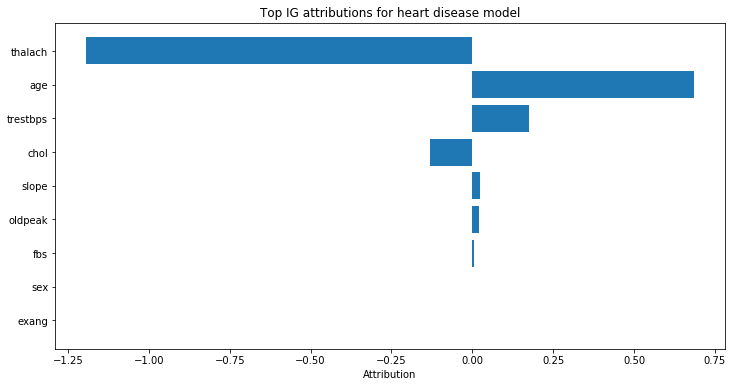

In [17]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig = plt.figure(figsize=(12, 6))
num_features = selected_point.shape[1] - 1
sorted_att_list = sorted(list(zip(np.abs(ex_ig.attributions), ex_ig.inputs, ex_ig.attributions)),
                         reverse=True)
out_list = [[f[1], f[2]] for f in sorted_att_list]
out_list = np.asarray(out_list[::-1])

plt.barh(list(range(num_features)), out_list[:,1].astype('float'))
plt.yticks(list(range(num_features)), out_list[:,0]);
plt.xlabel('Attribution')
plt.title(f'Top IG attributions for heart disease model')
plt.show()